# process Enlapse

## Library import

In [2]:
"""
Created on Mon Mar 15 14:59:48 2021

@author: G.R.E.G
"""

# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import copy

from sklearn import preprocessing
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## preprocess Fonction definiton

In [3]:

def hardcore_color_inv(mask):
    """
    Parameters:
    mask : cv2 gray img with only black and with px
    
    Returns:
    mask  --> with inversed black and with colors
    """
    for j in range(mask.shape[1]):
        for i in range(mask.shape[0]):
            flag = False #notifies if given px has already been modified
            if mask[i,j] == 0 :
                mask[i,j] = 255
                flag = True
            if mask[i,j] == 255 and not flag :
                mask[i,j] = 0
                flag = True
    return mask
            
def get_sub_img_coord(img):
    """
    give coord of a sub picture around the mask in order to reduce the size of data
    """
    flag_first = False
    coord_begin = np.zeros(shape = [2,1])
    coord_end = np.zeros(shape = [2,1])
    
    for j in range(img.shape[1]):
        for i in range(img.shape[0]):
            if img[i,j] == 255 :
                if not flag_first :
                    flag_first = True
                    coord_begin = np.array([i,j])
                else : 
                    coord_end = np.array([i,j])
    return [coord_begin , coord_end]
    


## Main

### data_preprocess

extraction of mask index and creation of sub picture

In [4]:
project_path = "C:/Users/G.R.E.G/Documents/Travail/test_technique_entreprise/enlapse/data/" 

In [5]:
path_mask = project_path + "2021-03-10_080001_mask.png"    
mask = cv2.imread(path_mask)
mask = cv2.cvtColor(mask , cv2.COLOR_RGB2GRAY)    
mask = hardcore_color_inv(mask)

res = get_sub_img_coord(mask)
coord_begin_mask = res[0]
coord_end_mask = res[1]
# margin around the mask for the sub picture to extract
margin = 100
coord_begin = coord_begin_mask - [margin , margin]
coord_end = coord_end_mask + [margin , margin]     

In [6]:
index = np.where(mask == 255)
print(index[0])
print(mask[index])

[439 439 439 ... 557 557 557]
[255 255 255 ... 255 255 255]


In [7]:
size = [ coord_end[0] - coord_begin[0] , coord_end[1] - coord_begin[1] ]
[ HEIGTH , WIDTH ] = size
[ HEIGTH , WIDTH ] = [256,256]
im_shape = [HEIGTH , WIDTH]
print(HEIGTH , WIDTH)

256 256


### Creation of datasets

2021-03-09_161001.jpg
2021-03-09_170001.jpg
2021-03-10_075001.jpg
2021-03-10_081001.jpg
2021-03-10_082001.jpg
2021-03-10_083001.jpg
(6, 256, 256, 1)
(6, 256, 256, 1)


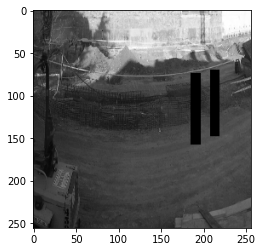

In [8]:
im_shape = np.array([1 , HEIGTH, WIDTH , 1])
x_dataset = np.empty(shape = im_shape)
y_dataset = np.empty(shape = im_shape)
for im_path in os.listdir(project_path):
    if im_path != "2021-03-10_080001_mask.png"  and im_path != "2021-03-10_080001.jpg" : 
        #if the file is not the file we need to correct and if the file is not the mask
        print(im_path)
        img_x = cv2.imread(project_path + im_path, cv2.IMREAD_GRAYSCALE)
        img_y = copy.deepcopy(img_x)
        img_x[index] = 0
        
        img_x = img_x[ coord_begin[0] : coord_end[1] , coord_begin[0] : coord_end[1] ]
        img_y = img_y[ coord_begin[0] : coord_end[1] , coord_begin[0] : coord_end[1] ]
        
        img_x = cv2.resize(img_x, (HEIGTH , WIDTH))
        img_y = cv2.resize(img_y, (HEIGTH , WIDTH))
        
        img_x= img_x / 255.0
        img_y = img_y / 255.0
        cv2.waitKey(0)
        img_x = np.asarray(img_x)
        img_y = np.asarray(img_y)
        img_x = img_x.reshape([1 , HEIGTH , WIDTH , 1])
        img_y = img_y.reshape([1 , HEIGTH , WIDTH , 1])
        
        x_dataset = np.vstack( (x_dataset , img_x) )
        y_dataset = np.vstack( (y_dataset , img_y) )
        
x_dataset =  x_dataset[1: , : , : , :]
y_dataset =  y_dataset[1: , : , : , :]
print(x_dataset.shape)
print(y_dataset.shape)
plt.imshow(x_dataset[2 ,  : , : , :] , cmap = "gray")

(6, 256, 256, 1)


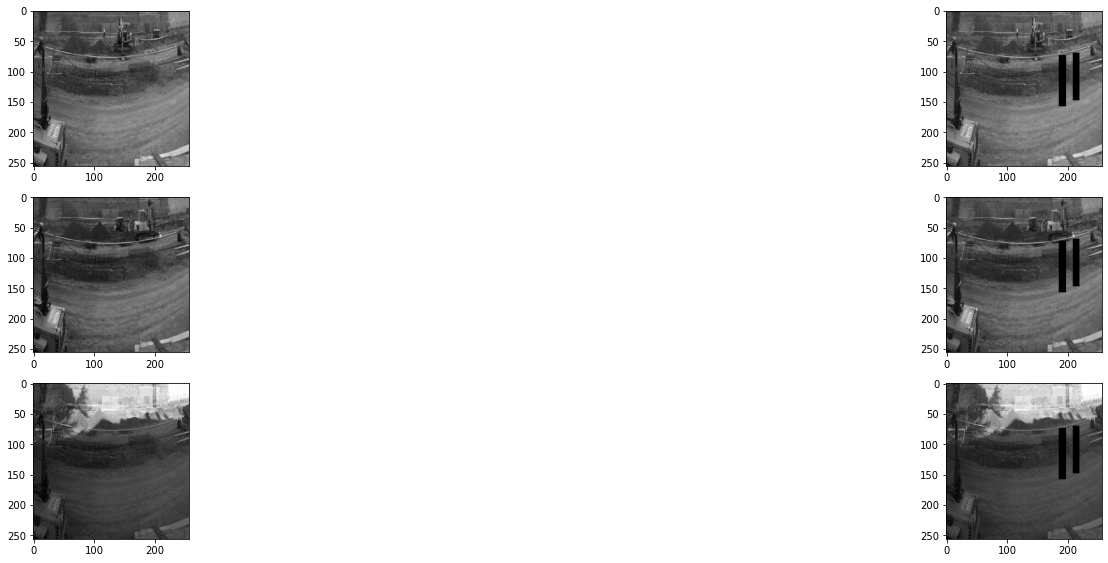

In [9]:
#data example
length = x_dataset.shape[0]
print(x_dataset.shape)
plt.figure( figsize = [30,20] )
i = 0
for cpt in np.arange(0 ,  length , 2  ):
    plt.subplot(length , 2 , cpt + 1 )
    plt.imshow(y_dataset[i ,:,:,: ] , cmap = "gray")
    plt.subplot(length ,2, cpt + 2)
    plt.imshow(x_dataset[i , :, : , : ] , cmap = "gray")
    i += 1

In [10]:
x_train , x_test , y_train , y_test = train_test_split(
    x_dataset, y_dataset, test_size=0.2, random_state=21
)
#print(x_train)
#print(x_test)

### Architecture

In [15]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(HEIGTH , WIDTH, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2 , name = "conv_1"),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2 , name = "conv_2"),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2 , name = "conv_3")
            ] , name = "encoder")
        """
        self.latent = tf.keras.Sequential([
          layers.Conv2D(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])
       """ 
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same' , name = "deconv_1"),
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same' , name = "deconv_2"),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same' , name = "deconv_3"),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same' , name = "out")] , name = "decoder")

    def call(self, x):
        encoded = self.encoder(x)
        #latent = self.latent(encoded)
        decoded = self.decoder(encoded)
        return decoded

    

In [16]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError() , metrics = ['accuracy'])
history = autoencoder.fit(x_train, x_train,
            epochs=100,
            shuffle=True,
            validation_data=(x_test, y_test),
            )



Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0857 - accuracy: 0.0192 - val_loss: 0.0741 - val_accuracy: 4.5776e-05
Epoch 2/100
1/1 [==============================] - 0s 296ms/step - loss: 0.0853 - accuracy: 0.0284 - val_loss: 0.0739 - val_accuracy: 1.5259e-05
Epoch 3/100
1/1 [==============================] - 0s 283ms/step - loss: 0.0849 - accuracy: 0.0285 - val_loss: 0.0736 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 292ms/step - loss: 0.0844 - accuracy: 0.0285 - val_loss: 0.0734 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 289ms/step - loss: 0.0839 - accuracy: 0.0285 - val_loss: 0.0731 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 300ms/step - loss: 0.0834 - accuracy: 0.0285 - val_loss: 0.0728 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 290ms/step - loss: 0.0828 - accuracy: 0.0285 - val_loss: 0.0725 - val_accuracy:

1/1 [==============================] - 0s 309ms/step - loss: 0.0384 - accuracy: 0.0285 - val_loss: 0.0624 - val_accuracy: 0.0000e+00
Epoch 58/100
1/1 [==============================] - 0s 302ms/step - loss: 0.0380 - accuracy: 0.0285 - val_loss: 0.0625 - val_accuracy: 0.0000e+00
Epoch 59/100
1/1 [==============================] - 0s 284ms/step - loss: 0.0378 - accuracy: 0.0285 - val_loss: 0.0623 - val_accuracy: 0.0000e+00
Epoch 60/100
1/1 [==============================] - 0s 281ms/step - loss: 0.0375 - accuracy: 0.0285 - val_loss: 0.0620 - val_accuracy: 0.0000e+00
Epoch 61/100
1/1 [==============================] - 0s 282ms/step - loss: 0.0372 - accuracy: 0.0285 - val_loss: 0.0616 - val_accuracy: 0.0000e+00
Epoch 62/100
1/1 [==============================] - 0s 296ms/step - loss: 0.0368 - accuracy: 0.0285 - val_loss: 0.0610 - val_accuracy: 0.0000e+00
Epoch 63/100
1/1 [==============================] - 0s 291ms/step - loss: 0.0364 - accuracy: 0.0285 - val_loss: 0.0602 - val_accuracy: 0.

### Results

loading and preprocessing img to predict

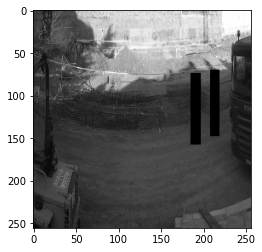

In [17]:
im_path = "2021-03-10_080001.jpg"
img = cv2.imread(project_path + im_path, cv2.IMREAD_GRAYSCALE)
img[index] = 0

img = img[ coord_begin[0] : coord_end[1] , coord_begin[0] : coord_end[1] ]
img = cv2.resize(img, (im_shape[1] , im_shape[2]) )
img = img / 255.0
img = np.asarray(img)
img = img.reshape([1 , HEIGTH , WIDTH , 1])
plt.imshow(img[0 ,  : , : , 0] , cmap = "gray")


Prédiction

(1, 256, 256, 1)


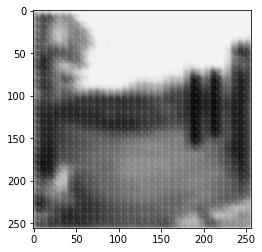

In [18]:
output = autoencoder.predict(img)
print(output.shape)
plt.imshow(output[0,:,:,0] , cmap = "gray")